# Aggregate multiple datasets to one

Thsi section defines some stuff for running the script. 

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import os
import itertools
import numpy as np
import pandas as pd

from results_helper import (
    MODELS, 
    MODELS_FULL,
    MODELS_SHORT,
    PROMPT_METHODS,
    DATASETS,
    DATASETS_FULL,
    DATASET_LENS,
    TARGET_DATASET,
    ROBUST_PATH,
    DATASET_PREFERENCES,
    METRICS,
    METRIC_LABELS,
    RELEVANCE, 
    RELEVANCE_DICT, 
)

from results_helper import aggregate, split_to_df_by_dataset
results_dict = aggregate(relevance=["relevant", "irrelevant", "irrelevant_set"], verbose=False, use_eval=True)

Found 36/156 full datasets


In [15]:
results_dict = split_to_df_by_dataset(results_dict, verbose=True)
print(results_dict)
results_dict.print_data()

MultiKeyDict with 300 entries:
Custom Keys: ['relevance', 'method', 'model', 'dataset', 'field']
Categorical Fields:
  - relevance(3): ['relevant', 'irrelevant_set', 'irrelevant']
  - method(4): ['direct', 'cot', 'icl', 'self_critic']
  - model(13): ['Llama-3.1-8B-Instruct', 'Llama-3.3-70B-Instruct-Turbo-Free', 'Mistral-7B-Instruct-v0.3', 'janus-7b', 'Mixtral-8x7B-Instruct-v0.1', 'gpt-4o-mini-2024-07-18', 'DeepSeek-R1-Distill-Llama-70B-free', 'gemma-2-9b-it', 'gemma-2-27b-it', 'Qwen3-8B', 'Qwen3-8B_thinking', 'Qwen3-32B', 'Qwen3-32B_thinking']
  - dataset(4): ['commonsense_qa', 'mmlu', 'truthful_qa', 'full']
  - Fields(len 2): ['dataset_path', 'df']

Data:
  - ('relevant', 'direct', 'Llama-3.1-8B-Instruct', 'full', 'dataset_path'): results/mcq_results/relevant/direct/full/Llama-3.1-8B-Instruct-direct-full_eval.csv
  - ('relevant', 'direct', 'Llama-3.3-70B-Instruct-Turbo-Free', 'full', 'dataset_path'): results/mcq_results/relevant/direct/full/Llama-3.3-70B-Instruct-Turbo-Free-direct-ful

## Table of scores

BR = 1-(Robust(q, P) | Correct_no_pref(q))

RDR = 1-(Robust(q, P) / Correct_no_pref(q))

AFR = 1 - (Robust(q, P) / Correct_pref(q, P))

PVR = (Correct_nopref(q) & Correct_pref(q, P)) / (Correct_nopref(q) | Correct_pref(q, P))

Compute per model, per dataset and full dataset

In [26]:
from results_helper import (MODELS_SHORT_DICT, compute_metrics, print_metric_table)

# Compute metrics
results_dict = compute_metrics(results_dict, verbose=False)

# # Debug print values
print_metric_table(
    results_dict,
    # relevances=["relevant"],
)

-------------------- ('relevant', 'Relevant') --------------------

-------------------- direct --------------------
Llama3-8B		& 11.8\% & 18.0\% & 18.1\% & 16.8\% & 12.8\% & 23.4\% & 19.9\% & 20.9\% & \textbf{1.1}\% & 6.6\% & 2.1\% & 5.0\% & 19.2\% & 30.8\% & 28.2\% & 28.3\% \\
Llama3-70B		& \textbf{3.1}\% & \textbf{6.0}\% & \textbf{7.3}\% & \textbf{5.6}\% & \textbf{4.3}\% & \textbf{10.1}\% & \textbf{9.9}\% & \textbf{9.0}\% & 1.2\% & 4.4\% & 2.8\% & 3.6\% & \textbf{6.5}\% & \textbf{10.2}\% & \textbf{12.0}\% & \textbf{9.8}\% \\
Mistral-7B		& 20.5\% & 27.3\% & 32.2\% & 26.3\% & 27.5\% & 34.4\% & 42.8\% & 33.8\% & 8.8\% & 9.8\% & 15.6\% & 10.2\% & 25.5\% & 37.2\% & 36.6\% & 34.6\% \\
Janus-7B		& 14.2\% & 24.7\% & 19.8\% & 21.9\% & 29.9\% & 34.7\% & 43.5\% & 34.6\% & 18.3\% & 13.3\% & 29.6\% & 16.3\% & 40.4\% & 48.5\% & 39.7\% & 45.9\% \\
Mixtral-8x7B		& 12.5\% & 18.2\% & 19.9\% & 17.3\% & 17.8\% & 27.0\% & 34.2\% & 26.1\% & 6.1\% & 10.8\% & 17.9\% & 10.7\% & 19.1\% & 27.6\% & 24.8\% & 25

## Scatter Plot of AVF vs BR

In [17]:
## TBD Code deleted by accident
from results_helper import filter_axis, named_scatter

scatter_metric_combos = [
    ("BR", "AFR", "RER")
]

for combo in scatter_metric_combos:
    metric1, metric2, metric3 = combo
    
    data, order = results_dict.get_field_matrix(
        field=[metric1, metric2, metric3],
        fixed_keys={
            "dataset": "full",
            "relevance": "relevant",
            "method": "direct",
        },
        axis_keys=["model"]
    )
    data = np.array(data)
    print(data.shape, order)
    
    data, _, scatter_model_names = filter_axis(
        data,
        axis=1,
        labels_to_filter=MODELS_SHORT,
    )
    print(data.shape, scatter_model_names)

    named_scatter(
        data[0],
        data[1],
        keys=scatter_model_names,
        title=f"{metric2} vs {metric1} Scatter Plot",
        xlabel=METRIC_LABELS[metric1],
        ylabel=METRIC_LABELS[metric2],
        scores=data[2],
        show=False,
    )

(3, 13) ['field', 'model']
(3, 12) ['Llama3-8B', 'Llama3-70B', 'Mistral-7B', 'Janus-7B', 'Mixtral-8x7B', 'GPT-4o-mini', 'DeepSeek-R1-70B', 'Gemma-2-9B', 'Gemma-2-27B', 'Qwen3-8B', 'Qwen3-8B-Thinking', 'Qwen3-32B']
Modifying


## Horizontal Bidirectional Bar Plot for Relevant/Mixed

(13, 3)
(5, 3)


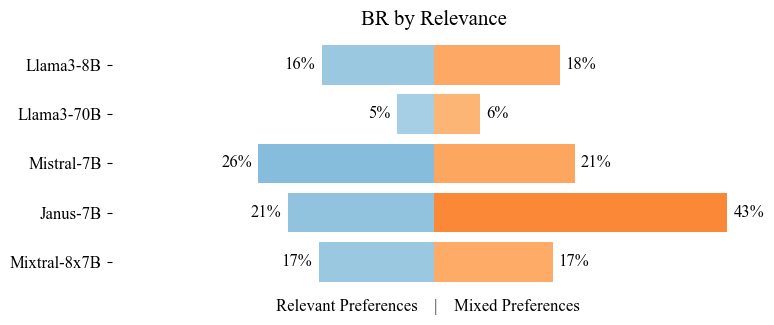

(13, 3)
(5, 3)


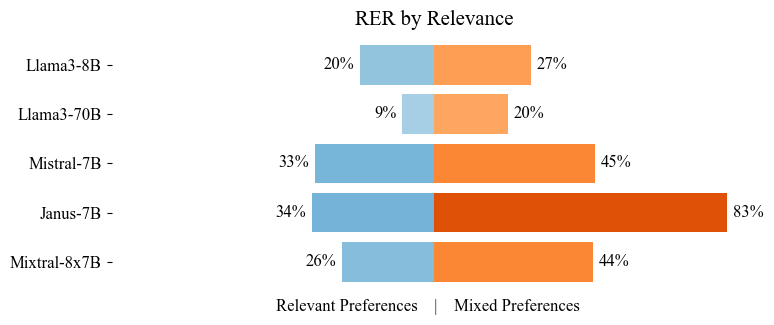

(13, 3)
(5, 3)


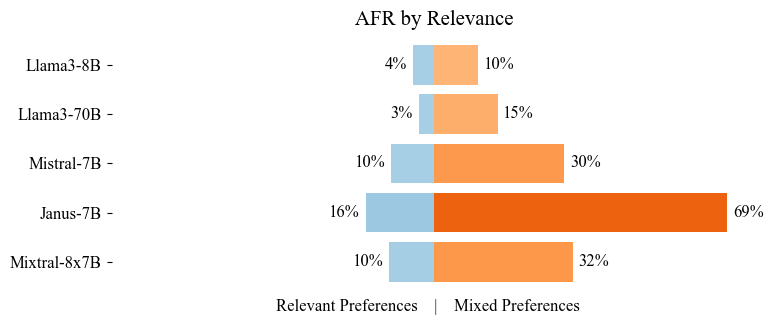

(13, 3)
(5, 3)


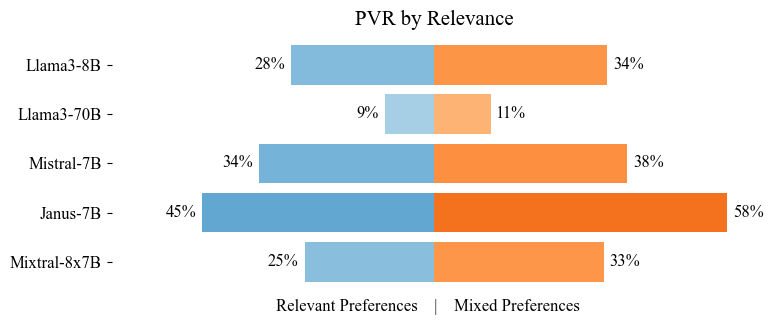

In [ ]:
from results_helper import rel_irrel_backback_barplot, filter_axis

matrices = []

for metric in METRICS:
    data, order = results_dict.get_field_matrix(
        field=metric,
        fixed_keys={
            "method": "direct",
            "dataset": "full",
        },
        axis_keys=["model", "relevance"]
    )
    data = np.array(data).squeeze()
    print(data.shape)
    data, _, model_names_rel_hb = filter_axis(
        data, 
        axis=0,
        filter_val=None,
        labels_to_filter=MODELS_SHORT,
    )
    print(data.shape)
    
    rel_irrel_backback_barplot(
        data[:, 0],
        data[:, 1],
        models=model_names_rel_hb,
        title=f"{metric} by Relevance",
        show=False,
    )



## Horizontal Bar Plot for Relevant/Irrelevant/Mixed

(13, 3)
(5, 3)


<string>:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


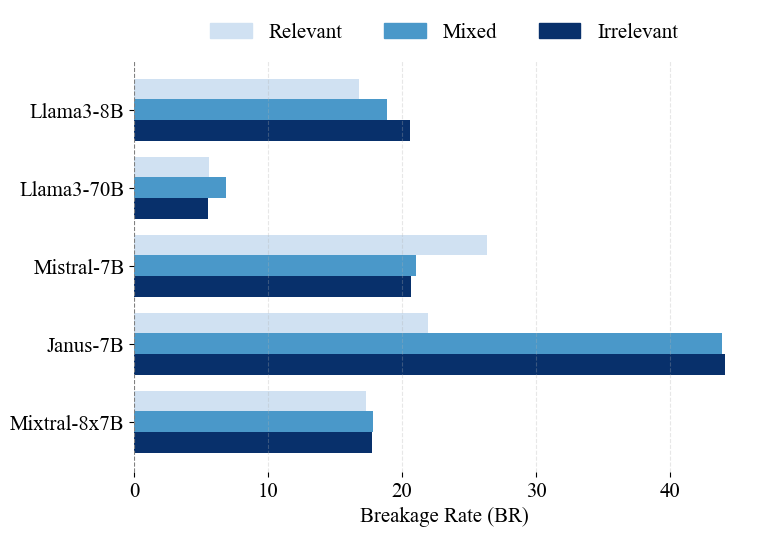

(13, 3)
(5, 3)


<string>:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


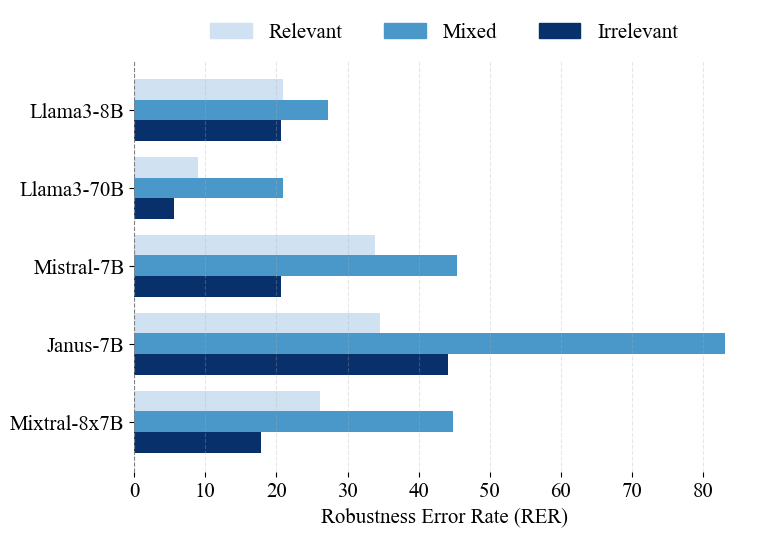

(13, 3)
(5, 3)


<string>:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


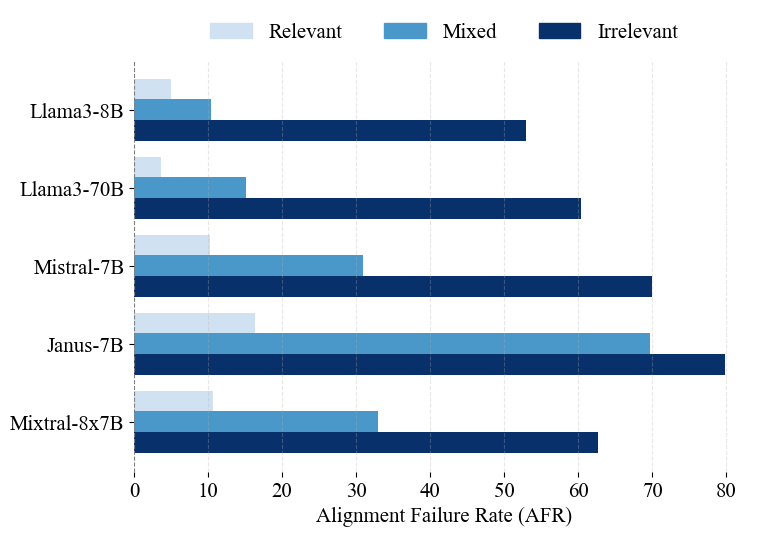

(13, 3)
(5, 3)


<string>:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


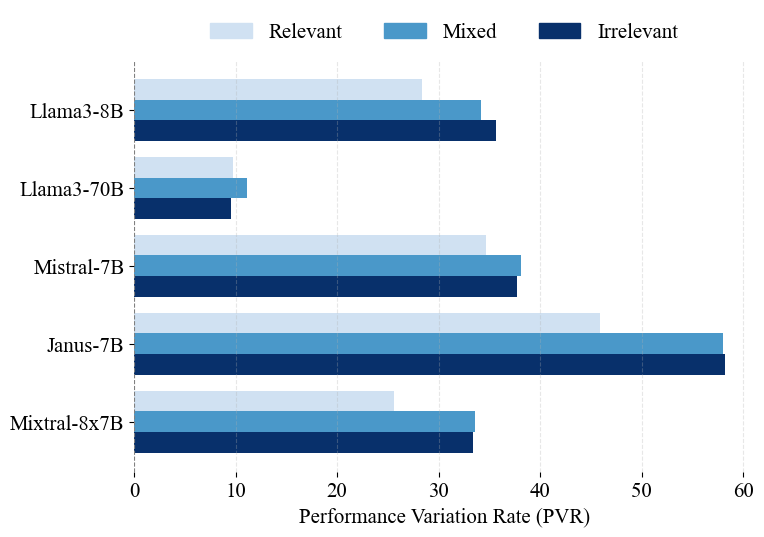

In [ ]:
from results_helper import relevance_hbarplot, filter_axis

matrices = []

for metric in METRICS:
    data, order = results_dict.get_field_matrix(
        field=metric,
        fixed_keys={
            "method": "direct",
            "dataset": "full",
        },
        axis_keys=["model", "relevance"]
    )
    data = np.array(data).squeeze()
    print(data.shape)
    data, _, model_names_rel_hb = filter_axis(
        data, 
        axis=0,
        filter_val=None,
        labels_to_filter=MODELS_SHORT,
    )
    print(data.shape)
    
    relevance_hbarplot(
        data,
        relevance_list=RELEVANCE,
        models=model_names_rel_hb,
        title=f"{metric} by Relevance",
        xlabel=METRIC_LABELS[metric],
        show=False,
    )



## Horizontal Bar Plot for Prompt Methods

In [20]:
from results_helper import metric_hbarplot, filter_axis

matrices = []

for metric in METRICS:
    data, order = results_dict.get_field_matrix(
        field=metric,
        fixed_keys={
            "relevance": "relevant",
            "dataset": "full",
        },
        axis_keys=["model", "method"]
    )
    data = np.array(data).squeeze()
    print(data.shape)

    data, _, model_names_hb = filter_axis(
        data, 
        axis=0,
        filter_val=None,
        labels_to_filter=MODELS_SHORT,
    )
    print(data.shape)
    matrices.append(data)

metric_hbarplot(
    matrices,
    methods=PROMPT_METHODS,
    models=model_names_hb,
    subplot_titles=METRICS,
    title="Metrics with Various Prompting Methods",
    show=False,
)


(13, 4)
(4, 4)
(13, 4)
(4, 4)
(13, 4)
(4, 4)
(13, 4)
(4, 4)


## Heatmap of zero shot per dataset

In [21]:
# Example definitions (replace with your actual lists)

# Dictionaries to store the difference (dataset performance - full dataset performance)
robustness_diff = {}
nopref_diff = {}
pref_diff = {}

# Loop over each model and compute differences
for model in MODELS:
    # Construct the file path for the full dataset
    full_dataset_path = os.path.join("results", "mcq_results", "relevant", "direct", "full", f"{model}-direct-full.csv")
    
    # If the file does not exist, assign NaNs for each dataset
    if not os.path.exists(full_dataset_path):
        print(f"Warning: Full dataset not found for {model}, skipping computation.")
        robustness_diff[model] = {ds: np.nan for ds in DATASETS_FULL}
        nopref_diff[model] = {ds: np.nan for ds in DATASETS_FULL}
        pref_diff[model] = {ds: np.nan for ds in DATASETS_FULL}
        continue

    full_df = pd.read_csv(full_dataset_path)

    # Compute overall full dataset metrics
    full_robustness = full_df.loc[full_df['nopref_correct'] == 1, 'pref_correct'].mean() * 100
    full_nopref = full_df['nopref_correct'].mean() * 100
    full_pref = full_df['pref_correct'].mean() * 100

    # Initialize inner dictionaries for the current model
    robustness_diff[model] = {}
    nopref_diff[model] = {}
    pref_diff[model] = {}

    # Compute metrics for each individual dataset and then their differences versus the full dataset
    for ds in DATASETS_FULL:
        dataset_df = full_df[full_df["source"] == ds]
        # Compute dataset metrics (multiplying by 100 to express percentages)
        ds_robustness = dataset_df.loc[dataset_df['nopref_correct'] == 1, 'pref_correct'].mean() * 100
        ds_nopref = dataset_df['nopref_correct'].mean() * 100
        ds_pref = dataset_df['pref_correct'].mean() * 100
        
        # Calculate differences (dataset - full)
        robustness_diff[model][ds] = ds_robustness
        nopref_diff[model][ds] = ds_nopref
        pref_diff[model][ds] = ds_pref

# Organize each metric difference into a DataFrame.
# Using .from_dict(..., orient='index') returns rows as models.
# We then take .T so rows become datasets and columns become models.
heatmap_data = {
    "robustness": pd.DataFrame.from_dict(robustness_diff, orient="index").T,
    "nopref_correctness": pd.DataFrame.from_dict(nopref_diff, orient="index").T,
    "pref_correctness": pd.DataFrame.from_dict(pref_diff, orient="index").T,
}

# Now, plot a heatmap for each metric
for metric, df in heatmap_data.items():
    plt.figure(figsize=(8, 8))
    ax = sns.heatmap(df, annot=True, fmt=".2f", cmap="viridis", cbar=True, square=True)
    # Ensure model names (columns) are rotated for clarity
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    plt.title(f'Heatmap of {metric}')
    plt.ylabel("Datasets")
    plt.xlabel("Models")
    
    # Create directory if not existing and save the plot
    figpath = os.path.join(stats_folder, f"{metric}_heatmap.png")
    os.makedirs(os.path.dirname(figpath), exist_ok=True)
    plt.savefig(figpath, dpi=300)
    plt.show()
    plt.close()


# ------------------------------------------------------------------
# Separate scatter plots (8×5 each) with orange regression line
# ------------------------------------------------------------------
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Re‑use dataframes created earlier
robust_df = heatmap_data["robustness"]
nopref_df = heatmap_data["nopref_correctness"]
pref_df   = heatmap_data["pref_correctness"]

# ------------------------------------------------------------------
# Helper to build and save a single plot
# ------------------------------------------------------------------
def make_scatter(x_vals, y_vals, x_label, title, fname):
    # Mask NaNs
    mask = ~np.isnan(x_vals) & ~np.isnan(y_vals)
    x = x_vals[mask]
    y = y_vals[mask]

    # Correlation + best‑fit line
    r_val, _ = pearsonr(x, y)
    m, b = np.polyfit(x, y, 1)
    x_line = np.linspace(x.min(), x.max(), 100)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.scatter(x, y, alpha=0.7)
    plt.plot(x_line, m * x_line + b, color="orange", linewidth=2)
    plt.xlabel(x_label)
    plt.ylabel("Robustness (%)")
    plt.title(f"{title}\n$r={r_val:.2f}$")
    plt.tight_layout()

    # Save & show
    out_path = os.path.join(stats_folder, fname)
    plt.savefig(out_path, dpi=300)
    plt.show()
    plt.close()

# ------------------------------------------------------------------
# 1) No‑pref accuracy vs. robustness
# ------------------------------------------------------------------
make_scatter(
    x_vals=nopref_df.values.flatten(),
    y_vals=robust_df.values.flatten(),
    x_label="No‑pref accuracy (%)",
    title="No‑pref Accuracy vs. Robustness",
    fname="nopref_vs_robustness_scatter.png"
)

# ------------------------------------------------------------------
# 2) Pref accuracy vs. robustness
# ------------------------------------------------------------------
make_scatter(
    x_vals=pref_df.values.flatten(),
    y_vals=robust_df.values.flatten(),
    x_label="Pref accuracy (%)",
    title="Pref Accuracy vs. Robustness",
    fname="pref_vs_robustness_scatter.png"
)

KeyError: 'nopref_correct'

## Bar Plot of Prompt Methods

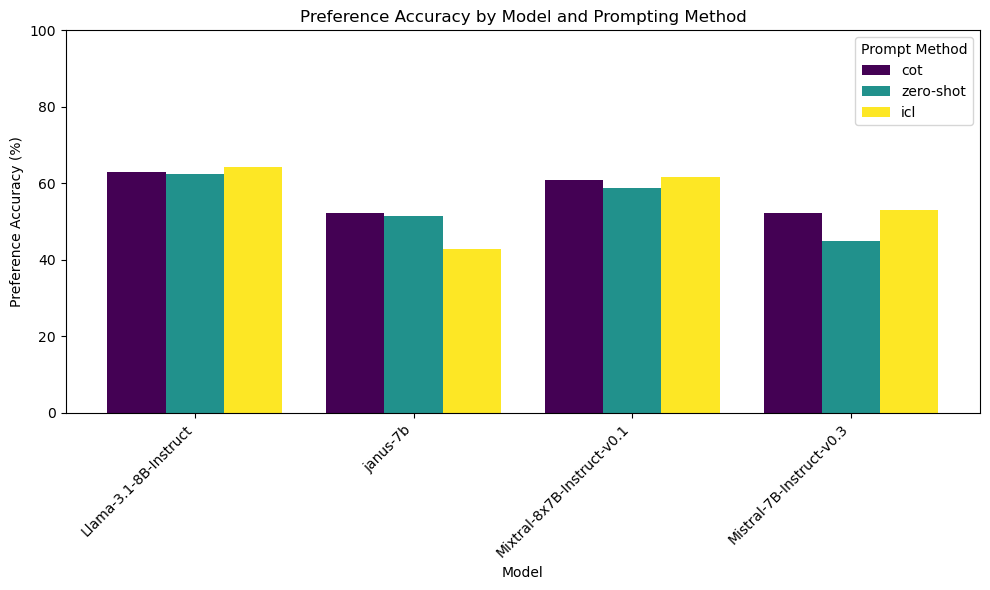

In [ ]:
# Initialize a nested dictionary to store the preference accuracy values.
# We use a list for each (model, prompt method) so that if there are multiple entries,
# we can average the results.
results = {model: {method: [] for method in PROMPT_METHODS} for model in MODELS}

# Process each valid combination.
for method, model, full_dataset_path in valid_combinations:
    if full_dataset_path is None:
        print(f"Skipping {method}, {model} as no full dataset found.")
        value = 0.0
    else:
        full_df = pd.read_csv(full_dataset_path)
        # Compute the preference correctness (mean of 'pref_correct' * 100).
        value = full_df['pref_correct'].mean() * 100
    results[model][method].append(value)

# In case there are multiple entries per (model, method) combination,
# average them. If there are no entries, we keep 0.0.
for model in results:
    for method in results[model]:
        if results[model][method]:
            results[model][method] = np.mean(results[model][method])
        else:
            results[model][method] = 0.0

# Prepare the data for plotting.
# The x-axis groups are by model.
indices = np.arange(len(MODELS))

# For each prompt method, collect a list of accuracy values in the same order as MODELS.
bar_data = {}
for method in PROMPT_METHODS:
    bar_data[method] = [results[model][method] for model in MODELS]

# Set up parameters for the grouped bar chart.
num_methods = len(PROMPT_METHODS)
total_width = 0.8  # Total width of all bars in a group.
bar_width = total_width / num_methods

# Create the bar plot.
fig, ax = plt.subplots(figsize=(10, 6))

# Define a colormap and extract a color for each prompt method.
cmap = plt.get_cmap('viridis', num_methods)
colors = [cmap(i) for i in range(num_methods)]

# Plot each prompt method’s bars, offsetting their positions within each group.
for i, method in enumerate(PROMPT_METHODS):
    if method == "direct":
        print_method = "zero-shot"
    else:
        print_method = method
    offset = (i - (num_methods - 1) / 2) * bar_width  # Center the bars in each group.
    ax.bar(indices + offset, bar_data[method], width=bar_width, label=print_method, color=colors[i])

# Label the x-axis with model names.
ax.set_xticks(indices)
# ax.set_xticklabels(MODELS)
ax.set_xticklabels(MODELS, rotation=45, ha="right")
ax.set_xlabel("Model")
ax.set_ylabel("Preference Accuracy (%)")
ax.set_ylim(0, 100)  # Fix y-axis range
ax.set_title("Preference Accuracy by Model and Prompting Method")
ax.legend(title="Prompt Method")

plt.tight_layout()

# Save the plot.
figpath = os.path.join(stats_folder, f"{criterion}_{dataset_short}_preference_accuracy.png")
os.makedirs(os.path.dirname(figpath), exist_ok=True)
plt.savefig(figpath, dpi=300)

# Display the plot.
plt.show()
plt.close()


## Make the line graph

/var/folders/td/cprp00894xq2p_fbrnfj89vr0000gn/T/ipykernel_94129/204394305.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


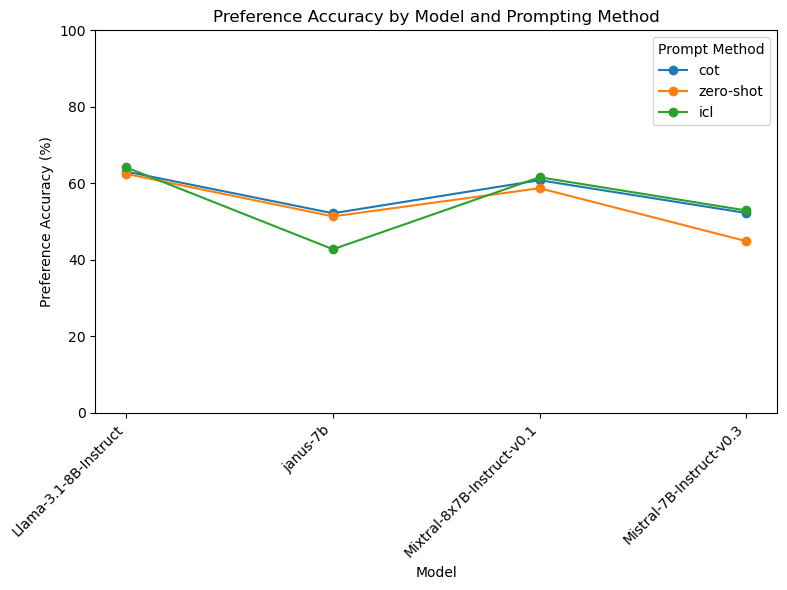

In [ ]:
# Create a new figure for the line plot.
fig, ax = plt.subplots(figsize=(8, 6))

# For each prompt method, extract the accuracy values across models and plot them.
for method in PROMPT_METHODS:
    # Use a different label if the method is "direct"
    print_method = "zero-shot" if method == "direct" else method
    
    # Generate a list of accuracy values for this prompt method in the same order as MODELS.
    y_values = [results[model][method] for model in MODELS]
    
    # Create the line graph with markers.
    ax.plot(MODELS, y_values, marker='o', label=print_method)

# Label axes, set limits, title, and legend.
ax.set_xlabel("Model")
ax.set_ylabel("Preference Accuracy (%)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_ylim(0, 100)  # Fix the y-axis range
ax.set_title("Preference Accuracy by Model and Prompting Method")
ax.legend(title="Prompt Method")

plt.tight_layout()

# Save the plot to a file. Adjust the path and filename as required.
figpath = os.path.join(stats_folder, f"{criterion}_{dataset_short}_preference_accuracy_line.png")
os.makedirs(os.path.dirname(figpath), exist_ok=True)
plt.savefig(figpath, dpi=300)

# Display the plot.
plt.show()
plt.close()

## New Metrics